In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [1]:
from datasets import load_dataset

dataset = load_dataset("jaygala223/38-cloud-train-only-v2")

f:\JAY\0.CVSSP\NeurIPS climate change workshop - cloud detection\code\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8400
    })
})

In [3]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [4]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 7560
})
Dataset({
    features: ['image', 'label'],
    num_rows: 840
})


In [5]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"jaygala223/38-cloud-train-only-v2"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'non-cloud', 1: 'cloud'}


In [6]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        # adding one bottom most pixel as 255 since processor/feature_extractor
        # wont take labels without a positive (i.e. class: 1 or cloud)
        uniques = np.unique(original_segmentation_map)
        if sum(uniques) == 0:
            original_segmentation_map[-1, -1] = 255

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [7]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)

In [8]:
from transformers import MaskFormerImageProcessor,Mask2FormerImageProcessor, AutoImageProcessor

size = {'longest_edge':384, 'shortest_edge':384}

#original
preprocessor = Mask2FormerImageProcessor(ignore_index=0,
                                        do_reduce_labels=False,
                                        do_resize=False,
                                        do_rescale=False,
                                        do_normalize=True,
                                        size=size)


In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [13]:
import torch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])
mask_labels torch.Size([1, 384, 384])
class_labels torch.Size([1])
original_images (384, 384, 3)
original_segmentation_maps (384, 384)


In [14]:
import torch

def binarize_image(image, threshold = 50):
    """
    Binarizes a color image.

    Args:
        image (torch.Tensor): Input color image of shape [1, H, W, 3].
        threshold (float): Threshold value for binarization (between 0 and 255).

    Returns:
        torch.Tensor: Binarized image of shape [1, H, W].
    """
    image = image.float()
    # Convert the image to grayscale by taking the average across color channels
    gray_image = torch.mean(image, dim=3, keepdim=True)  # Shape: [1, H, W, 1]

    # Apply binarization based on the threshold
    binary_image = torch.where(gray_image >= threshold, torch.ones_like(gray_image), torch.zeros_like(gray_image))

    return binary_image.squeeze(dim=3)

In [15]:
import torch

def binarize_image_learnable(image, threshold):
    """
    Binarizes a color image.

    Args:
        image (torch.Tensor): Input color image of shape [1, H, W, 3].
        threshold (float): Threshold value for binarization (between 0 and 255).

    Returns:
        torch.Tensor: Binarized image of shape [1, H, W].
    """
    image = image.float()
    alpha = 1
#     threshold = torch.clamp(threshold,min=0.0, max=1.0)
    threshold_l = 255*(0.55 - alpha*torch.sigmoid(threshold))
    print(threshold)

    # Convert the image to grayscale by taking the average across color channels
    gray_image = torch.mean(image, dim=3, keepdim=True)  # Shape: [1, H, W, 1]

    # Apply binarization based on the threshold
    binary_image = torch.where(gray_image >= threshold_l, torch.ones_like(gray_image), torch.zeros_like(gray_image))
    print(threshold.grad,binary_image.grad)
    return binary_image.squeeze(dim=3)

In [16]:
def maskformer_forward_pass(model, feature_extractor, images, labels, device):
    inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    inputs['pixel_values'] = inputs['pixel_values'].float()

    inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
    inputs['class_labels'] = torch.stack(inputs['class_labels'])

    inputs.to(device)

    outputs = model(**inputs)

    return outputs

In [ ]:
def upernet_forward_pass(model, image_processor, images, labels, device):
    inputs = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')
    inputs.to(device)

    outputs = model(**inputs)

    return outputs

In [17]:
from torchvision.transforms import ToPILImage
import PIL.Image as Image

def display_tensor_as_pil(tensor):
    tensor = (tensor * 255).byte()

    # Convert the PyTorch tensor to a PIL image
    to_pil = ToPILImage()
    pil_image = to_pil(tensor)

    return pil_image

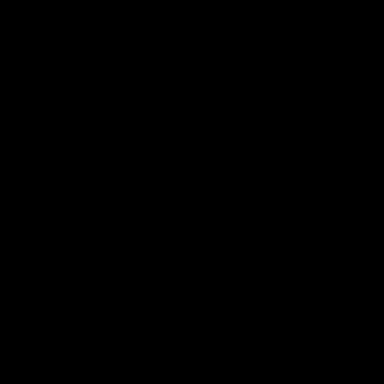

In [39]:
# images.shape
display_tensor_as_pil(images.permute(0,3,1,2)[0])

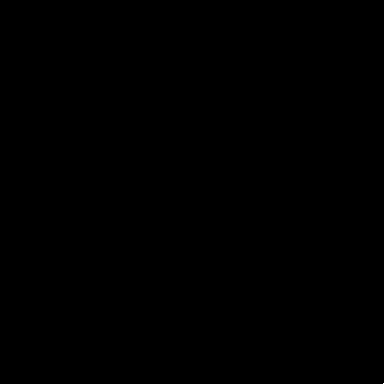

In [40]:
# labels.shape
display_tensor_as_pil(labels)

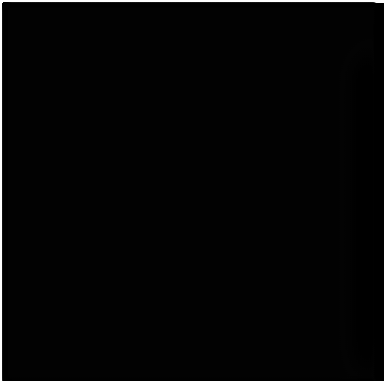

In [41]:
# outputs[0].shape
display_tensor_as_pil(outputs[0])

In [ ]:
# import torchvision

# model = torchvision.models.segmentation.fcn_resnet50(num_classes=1)
# model

# note: if using this fcn model then use the following function during training and eval

# def fcn_forward_pass(model, images, device):
#     model.to(device)
#     images.to(device)
    
#     outputs = model(images.float().permute(0,3,1,2))

#     outputs = torch.sigmoid(outputs['out'])
#     return outputs

In [19]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32)

finetuned_model = torch.load("unet_finetuned_47_iou.pth")
# finetuned_model.state_dict()
model.load_state_dict(finetuned_model.state_dict())

Using cache found in C:\Users\jayga/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

In [20]:
def unet_forward_pass(model, images, device):
    model.to(device)
    images.to(device)

    outputs = model(images.float().permute(0,3,1,2))
    # outputs = (outputs > 0).float()
    return outputs

In [38]:
device = "cuda"

batch = next(iter(train_dataloader))

# model = torch.load()

images, labels = batch['original_images'], batch['original_segmentation_maps']

# first convert to np array then to tensor... because list to tensor is a slow operation
images = np.array(images)
images = torch.tensor(images)
labels = np.array(labels)
labels = torch.tensor(labels)/255

# print(images.shape)

images.to(device)
labels.to(device)
model.to(device)

new_labels = binarize_image(images, threshold=55)

# if there is only single cloud (i.e. 1) pixel then leave it
# or if all elements in new_labels are 1 then leave it (because image may have SNOW)
# note: binarization does poorly on snowy images.
# if (labels == 1).all().item() == 1 or (labels == 0).all().item() == 1:
#     new_labels = labels

outputs = unet_forward_pass(model.to(device), images.to(device), device)

# outputs = upernet_forward_pass(model, image_processor,images, labels, device)

print("done!")

done!


In [ ]:
outputs.shape

TRAINING

In [ ]:
# model=torch.load('unet_checkpoint_44_iou.pth')

In [18]:
def calculate_iou(pred_mask_list, true_mask_list):
    total_iou = 0.0
    num_masks = len(pred_mask_list)

    for pred_mask, true_mask in zip(pred_mask_list, true_mask_list):
        pred_mask = pred_mask.cpu()
        true_mask = true_mask.cpu()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()

        iou = intersection.float() / union.float()
        total_iou += iou.item()

    avg_iou = total_iou / num_masks
    return avg_iou

In [19]:
import torch

def calculate_metrics(true_labels, predicted_labels, device):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for true, predicted in zip(true_labels, predicted_labels):
        true.to(device)
        predicted.to(device)
        true_positives += torch.sum((predicted == 1) & (true == 1)).item()
        false_positives += torch.sum((predicted == 1) & (true == 0)).item()
        false_negatives += torch.sum((predicted == 0) & (true == 1)).item()
        true_negatives += torch.sum((predicted == 0) & (true == 0)).item()

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, accuracy, f1_score

# Example usage
true_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]
predicted_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]

precision, recall, accuracy, f1_score = calculate_metrics(true_labels, predicted_labels, "cpu")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

Precision: 0.9999999750000006
Recall: 0.9999999750000006
Accuracy: 0.9999999833333336
F1 Score: 0.9999999250000032


In [20]:
def calculate_iou_from_tensors(predicted, target):
    """
    Calculate Intersection over Union (IoU) between two tensors.

    Args:
        predicted (torch.Tensor): Predicted binary tensor.
        target (torch.Tensor): Ground truth binary tensor.

    Returns:
        float: Intersection over Union (IoU) score.
    """
    intersection = torch.logical_and(predicted, target).sum()
    union = torch.logical_or(predicted, target).sum()
    iou = float(intersection) / float(union + 1e-6)  # Add a small epsilon to avoid division by zero
    return iou

In [42]:
torch.cuda.empty_cache()

In [43]:
# BINARIZATION TRAINING

import torch
from tqdm.auto import tqdm
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCEWithLogitsLoss()

model_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

learnable_threshold = 60.0
delta_x = 2.0
best_loss = float('inf')
lower_bound = 50.0
update_frequency = 100 #for binarization thresholding

running_loss = 0.0
num_samples = 0
batch_size = 1

train_losses = []
accuracies = []
f1_scores = []
mIoU_scores = []
recalls = []
precisions = []
iterations = []

for epoch in range(2):
  print("Epoch:", epoch)
  model.train()
  if_condition = 0
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      model_optimizer.zero_grad()
      torch.cuda.empty_cache()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)
      model.to(device)

      new_labels = binarize_image(images, threshold=learnable_threshold)

      outputs = unet_forward_pass(model.to(device), images.to(device), device)
    
      # Backward propagation
      loss = criterion(outputs.float().to(device), new_labels.float().unsqueeze(dim=1).to(device))

      if loss.item() < best_loss:
            best_loss = loss.item()

      if (idx + 1) % update_frequency == 0:
          # Adjust the threshold every 'update_frequency' iterations
          if loss.item() > best_loss:
              learnable_threshold -= delta_x  # Decrease the threshold
          else:
              learnable_threshold += delta_x  # Increase the threshold
          if learnable_threshold < lower_bound:
              learnable_threshold += 10.0

      loss.backward()
      # Optimization
      model_optimizer.step()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size
        
      train_losses.append(running_loss / num_samples)

      # Calculate and append evaluation metrics (assuming evaluate returns a dictionary)
      evaluation_metrics = evaluate(model, test_dataloader, num_batches=5)
      accuracies.append(evaluation_metrics['accuracy'])
      f1_scores.append(evaluation_metrics['f1_score'])
      mIoU_scores.append(evaluation_metrics['mIoU'])
      recalls.append(evaluation_metrics['recall'])
      precisions.append(evaluation_metrics['precision'])

      # Append iteration count
      iterations.append(idx)

      if idx % 50 == 0:
        print("Loss:", running_loss/num_samples, "\n")
        print("Threshold value", learnable_threshold, "\n")

Epoch: 0


  0%|          | 0/1890 [00:00<?, ?it/s]

Loss: 0.15953756868839264 

Threshold value 60.0 

Loss: 0.16163520602618947 

Threshold value 60.0 

Loss: 0.15930181579424604 

Threshold value 58.0 

Loss: 0.15644281017069786 

Threshold value 58.0 

Loss: 0.15710199850412152 

Threshold value 56.0 

Loss: 0.1570438030825193 

Threshold value 56.0 

Loss: 0.15688942412403334 

Threshold value 54.0 

Loss: 0.1572680371439355 

Threshold value 54.0 

Loss: 0.15678024351448192 

Threshold value 52.0 

Loss: 0.1567072868347168 

Threshold value 52.0 

Loss: 0.15628958941100837 

Threshold value 50.0 

Loss: 0.15590350470503964 

Threshold value 50.0 

Loss: 0.15562864448782213 

Threshold value 58.0 

Loss: 0.15597980072329853 

Threshold value 58.0 

Loss: 0.15599278975995562 

Threshold value 56.0 

Loss: 0.15601588065392485 

Threshold value 56.0 

Loss: 0.1560070811772019 

Threshold value 54.0 

Loss: 0.15611911164957823 

Threshold value 54.0 

Loss: 0.15595456352509088 

Threshold value 52.0 

Loss: 0.15567561903367158 

Thresho

  0%|          | 0/1890 [00:00<?, ?it/s]

Loss: 0.15473784129260898 

Threshold value 54.0 

Loss: 0.15474574487811815 

Threshold value 54.0 

Loss: 0.15467219869360618 

Threshold value 52.0 

Loss: 0.15449043761597492 

Threshold value 52.0 

Loss: 0.15449111869835727 

Threshold value 50.0 

Loss: 0.15444279424515578 

Threshold value 50.0 

Loss: 0.15438090839148222 

Threshold value 58.0 

Loss: 0.15443742291196444 

Threshold value 58.0 

Loss: 0.1544048022535731 

Threshold value 56.0 

Loss: 0.15441687189007558 

Threshold value 56.0 

Loss: 0.15437661447581363 

Threshold value 54.0 

Loss: 0.15433072398879497 

Threshold value 54.0 

Loss: 0.1542914180284712 

Threshold value 52.0 

Loss: 0.15433243761518628 

Threshold value 52.0 

Loss: 0.15429541291485693 

Threshold value 50.0 

Loss: 0.1542506595732858 

Threshold value 50.0 

Loss: 0.15419494149710156 

Threshold value 58.0 

Loss: 0.1542530134428987 

Threshold value 58.0 

Loss: 0.1542292702602725 

Threshold value 56.0 

Loss: 0.1541860771012407 

Threshold

In [44]:
for i in range(3780):
    iterations[i] = i
    
iterations[1891]

1891

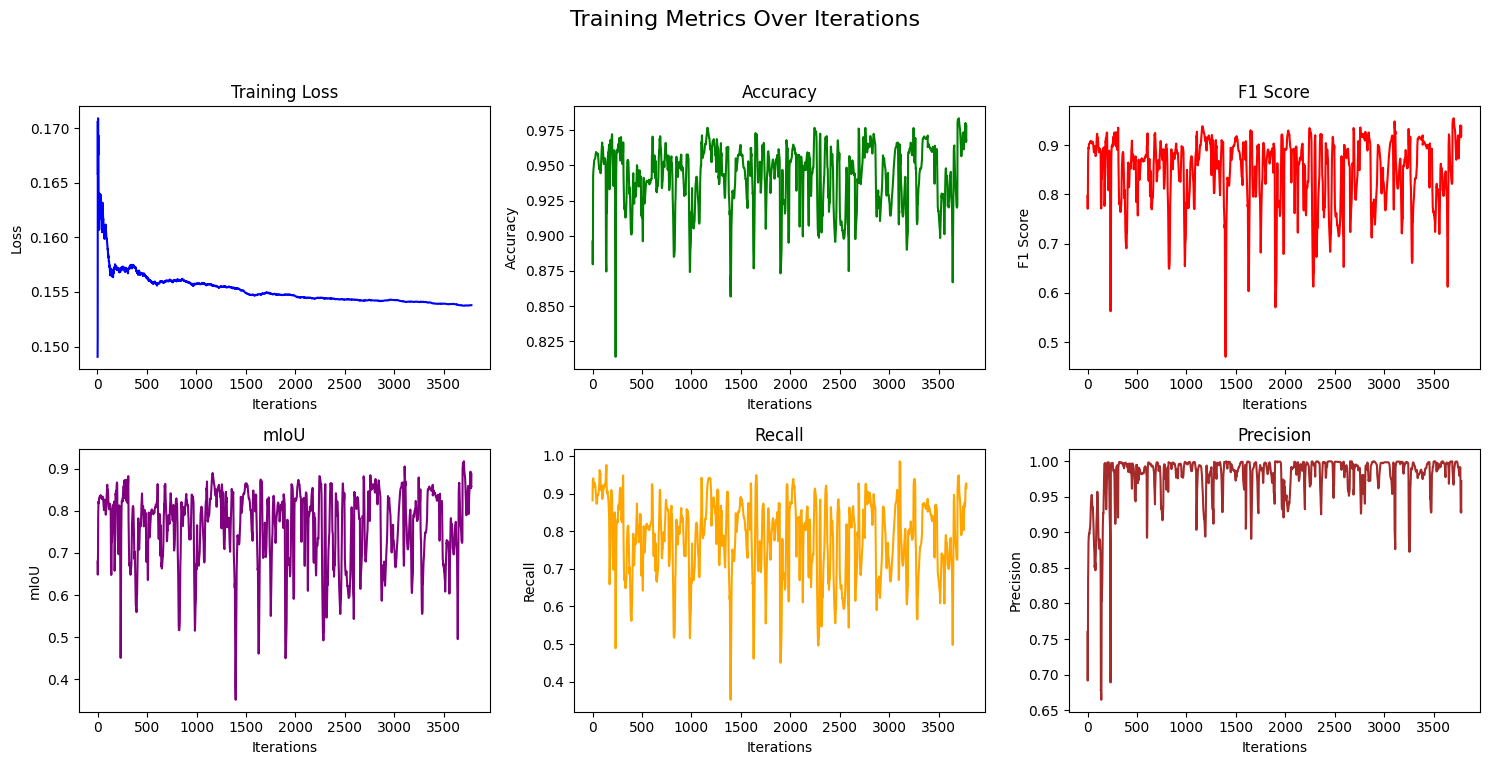

In [45]:
import matplotlib.pyplot as plt
import matplotlib

# Convert lists to NumPy arrays for plotting
train_losses = np.array(train_losses)
accuracies = np.array(accuracies)
f1_scores = np.array(f1_scores)
mIoU_scores = np.array(mIoU_scores)
recalls = np.array(recalls)
precisions = np.array(precisions)
iterations = np.array(iterations)

# Create subplots for multiple graphs
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Training Metrics Over Iterations', fontsize=16)

# Plot training loss
axes[0, 0].plot(iterations[1:], train_losses[1:], label='Train Loss', color='blue')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('Loss')

# Plot accuracy
axes[0, 1].plot(iterations, accuracies, label='Accuracy', color='green')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xlabel('Iterations')
axes[0, 1].set_ylabel('Accuracy')

# Plot F1 Score
axes[0, 2].plot(iterations, f1_scores, label='F1 Score', color='red')
axes[0, 2].set_title('F1 Score')
axes[0, 2].set_xlabel('Iterations')
axes[0, 2].set_ylabel('F1 Score')

# Plot mIoU
axes[1, 0].plot(iterations, mIoU_scores, label='mIoU', color='purple')
axes[1, 0].set_title('mIoU')
axes[1, 0].set_xlabel('Iterations')
axes[1, 0].set_ylabel('mIoU')

# Plot Recall
axes[1, 1].plot(iterations, recalls, label='Recall', color='orange')
axes[1, 1].set_title('Recall')
axes[1, 1].set_xlabel('Iterations')
axes[1, 1].set_ylabel('Recall')

# Plot Precision
axes[1, 2].plot(iterations, precisions, label='Precision', color='brown')
axes[1, 2].set_title('Precision')
axes[1, 2].set_xlabel('Iterations')
axes[1, 2].set_ylabel('Precision')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()

In [ ]:
learnable_threshold

In [ ]:
torch.save()

TESTING

In [46]:
from tqdm.auto import tqdm

def evaluate(model, test_dataloader, num_batches):
#     model.eval()
    device = "cuda"
    all_ious = []
    precisions, recalls, accuracies, f1_scores = [], [], [], []
    for idx, batch in enumerate(test_dataloader):
        if idx > num_batches:
            break
        images, labels = batch['original_images'], batch['original_segmentation_maps']

        images = np.array(images)
        images = torch.tensor(images)
        labels = np.array(labels)
        labels = torch.tensor(labels)/255

        images.to(device)
        labels.to(device)
        model.to(device)

        # Forward pass
        with torch.no_grad():

          new_labels = binarize_image(images, threshold=learnable_threshold)
          outputs = unet_forward_pass(model.to(device), images.to(device), device)
          outputs = torch.round(outputs)
 
        all_ious.append(calculate_iou_from_tensors(outputs.to(device), new_labels.unsqueeze(dim=1).to(device)))
        precision, recall, accuracy, f1_score = calculate_metrics(new_labels.unsqueeze(dim=1).to(device), outputs.to(device), device)
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1_scores.append(f1_score)

#     print("precision:", sum(precisions)/ len(precisions))
#     print("f1_score:", sum(f1_scores)/ len(f1_scores))
#     print("recall:", sum(recalls)/ len(recalls))
#     print("accuracy:", sum(accuracies)/ len(accuracies))
#     print("mIoU: ", sum(all_ious)/len(all_ious))
    
    return {'precision': sum(precisions)/ len(precisions), 
            'f1_score': sum(f1_scores)/ len(f1_scores),
            'recall': sum(recalls)/ len(recalls),
            'accuracy': sum(accuracies)/ len(accuracies),
            'mIoU': sum(all_ious)/len(all_ious)}

In [51]:
evaluate(model, test_dataloader, 210)

{'precision': 0.9637238070736616,
 'f1_score': 0.9644924855873707,
 'recall': 0.9667367315533367,
 'accuracy': 0.9861518012151106,
 'mIoU': 0.9315639186386384}

In [ ]:
torch.save(model.state_dict(), 'unet_finetuned_on_original_data.pth')

In [ ]:
precision: 0.6497505582459369
f1_score: 0.711377510275619
recall: 0.8297426301578141
accuracy: 0.9436292994530625
mIoU:  0.6457766028119563

In [ ]:
# torch.save(model, f'pretrained_unet_checkpoint_{sum(all_ious)/len(all_ious)}_iou.pth')

In [ ]:
# UNET last run at 25 percent loss:
precision: 0.7213244974024121
f1_score: 0.7090910715197316
recall: 0.7562019171459003
accuracy: 0.9088815955567087
mIoU:  0.4475010399949582

In [ ]:
print((outputs>0).float())

In [ ]:
# deeplabV3 finetuning
precision: 0.6400770810940861
f1_score: 0.630060150701847
recall: 0.6947887683204697
accuracy: 0.9036333840987757
mIoU:  0.3862483454377

In [ ]:
# swin tiny on PURELY NEW binarized LABELS
precision: 0.6152504039786425
f1_score: 0.5057209783787969
recall: 0.5720778575727808
accuracy: 0.8178325834725649
mIoU:  0.32597860723862077

# finetuned swin tiny on new binarized labels
precision: 0.751474905449785
f1_score: 0.6871745700037046
recall: 0.7321195578032763
accuracy: 0.8671422080385202
mIoU:  0.4677533339624049

In [ ]:
# MASKFORMER BEFORE LEARNABLE BINARIZATION
precision: 0.6140759422455014
f1_score: 0.6176200393516758
recall: 0.6242902578278914
accuracy: 0.9839068029674147
mIoU:  0.5901235823447888

# MASKFORMER AFTER LEARNABLE BINARIZATION


# last run
precision: 0.3062933478075279
f1_score: 0.34323185572017495
recall: 0.969535284181396
accuracy: 0.373442743152472
mIoU:  0.3061436470183687

precision 0.7754642685034004
f1_score 0.7528422777953474
recall 0.7397811585765738
accuracy 0.9775063871126577
mIoU:  0.7168471569364722

precision 0.5217402294425123
f1_score 0.5894180085336521
recall 0.999999981816197
accuracy 0.5217402294425123
mIoU:  0.521740224174788

* precision 0.3111225918183273
* f1_score 0.3191659886291905
* recall 0.3295510091217397
* accuracy 0.9829524113575062
* mIoU:  0.29805679046190703

* precision 0.26088595055841357
* f1_score 0.29013017962476445
* recall 0.3274049580908574
* accuracy 0.988511827256274
* mIoU:  0.25725841522216797

